In [1]:
using POMDPs, POMDPGym, Crux, Distributions, BSON, GridInterpolations, LinearAlgebra

┌ Warning: You are using Matplotlib 3.3.4, which is no longer
│ officialy supported by the Plots community. To ensure smooth Plots.jl
│ integration update your Matplotlib library to a version >= 3.4.0
│ 
│ If you have used Conda.jl to install PyPlot (default installation),
│ upgrade your matplotlib via Conda.jl and rebuild the PyPlot.
│ 
│ If you are not sure, here are the default instructions:
│ 
│ In Julia REPL:
│ ```
│ import Pkg;
│ Pkg.add("Conda")
│ import Conda
│ Conda.update()
│ Pkg.build("PyPlot")
│ ```
│ 
└ @ Plots /home/smkatz/.julia/packages/Plots/1KWPG/src/backends/pyplot.jl:29


In [2]:
using BSON: @save
using StatsFuns
using Random

In [3]:
using PGFPlots

In [4]:
pushPGFPlotsPreamble("\\usepgfplotslibrary{fillbetween}");

In [5]:
pushPGFPlotsPreamble("\\definecolor{dimgray}{rgb}{0.41, 0.41, 0.41}");

In [6]:
pushPGFPlotsPreamble("\\definecolor{lightgray}{rgb}{0.83, 0.83, 0.83}");

In [7]:
include("../../src/multilevel_estimation.jl")
include("../../src/montecarlo.jl")
include("../../src/gaussian_process.jl")
include("../../src/bandit.jl")
include("../../src/kernel_bandit.jl")
include("../../src/learning_bandit.jl")
include("../../src/pspec_bandit.jl")
include("controller.jl")
include("setup.jl")

pendulum_problem (generic function with 1 method)

# Load in the PSpec runs

In [13]:
ss1 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run1.bson")[:set_sizes_kkb]
ss2 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run2.bson")[:set_sizes_kkb]
ss3 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run3.bson")[:set_sizes_kkb]
ss4 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run4.bson")[:set_sizes_kkb]
ss5 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run5.bson")[:set_sizes_kkb];

In [15]:
ss1k = [s[2] for s in ss1]
ss2k = [s[2] for s in ss2]
ss3k = [s[2] for s in ss3]
ss4k = [s[2] for s in ss4]
ss5k = [s[2] for s in ss5];

In [28]:
ss = hcat(ss1k, ss2k, ss3k, ss4k, ss5k)
μ_ss = mean(ss, dims=2)[:]
σ_ss = std(ss, dims=2)[:];

# Convergence Plot

In [37]:
pred_hi = μ_ss .+ σ_ss
pred_lo = μ_ss .- σ_ss;

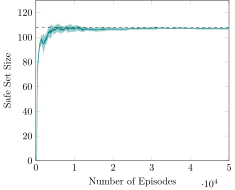

In [41]:
ax = Axis(Plots.Linear(collect(0:10:50000), μ_ss[1:10:end], mark="none", style="teal"))
push!(ax, Plots.Linear([0.0, 50000.0], [108.0, 108.0], mark="none", style="black, dashed"))
p_pred_hi = push!(ax, Plots.Linear(collect(0:10:50000), pred_hi[1:10:end], style="draw=none, mark=none, name path=A, forget plot"))
p_pred_lo = push!(ax, Plots.Linear(collect(0:10:50000), pred_lo[1:10:end], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[teal!40] fill between[of=A and B];"))
ax.xmin = 0.0
ax.xmax = 50000.0
ax.ymin = 0.0
ax.ymax = 130.0
ax.xlabel = "Number of Episodes"
ax.ylabel = "Safe Set Size"
ax

# Run Trials for Baseline

In [42]:
function pendulum_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return BanditModel(grid)
end

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

ss_b = []
for i = 1:5
    model_b = pendulum_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max)
    dkwucb_acquisition(model) = dkwucb_acquisition(model, problem.pfail_threshold, problem.conf_threshold)
    set_sizes_b = run_estimation!(model_b, problem, dkwucb_acquisition, 50000)
    push!(ss_b, set_sizes_b)
end

0.0%┣                                          ┫ 0/50.0k [00:00<-41:-40, -0s/it]
0.0%┣                                        ┫ 1/50.0k [00:08<Inf:Inf, InfGs/it]
0.0%┣                                         ┫ 12/50.0k [00:08<10:07:00, 1it/s]
0.1%┣                                         ┫ 75/50.0k [00:08<01:30:41, 9it/s]
0.2%┣                                       ┫ 105/50.0k [00:08<01:04:53, 13it/s]
0.3%┣▏                                         ┫ 168/50.0k [00:08<40:36, 20it/s]
0.5%┣▏                                         ┫ 233/50.0k [00:08<29:22, 28it/s]
0.6%┣▎                                         ┫ 295/50.0k [00:08<23:18, 36it/s]
0.7%┣▎                                         ┫ 350/50.0k [00:08<19:46, 42it/s]
0.8%┣▍                                         ┫ 424/50.0k [00:08<16:23, 50it/s]
1.0%┣▍                                         ┫ 479/50.0k [00:08<14:34, 57it/s]
1.1%┣▍                                         ┫ 529/50.0k [00:08<13:15, 62it/s]
1.1%┣▌                      


10.8%┣████▏                                  ┫ 5.4k/50.0k [00:14<01:52, 399it/s]
10.9%┣████▎                                  ┫ 5.4k/50.0k [00:14<01:51, 401it/s]
11.0%┣████▎                                  ┫ 5.5k/50.0k [00:14<01:50, 403it/s]
11.1%┣████▎                                  ┫ 5.5k/50.0k [00:14<01:50, 406it/s]
11.2%┣████▍                                  ┫ 5.6k/50.0k [00:14<01:49, 408it/s]
11.3%┣████▍                                  ┫ 5.6k/50.0k [00:14<01:48, 409it/s]
11.4%┣████▍                                  ┫ 5.7k/50.0k [00:14<01:48, 411it/s]
11.5%┣████▌                                  ┫ 5.7k/50.0k [00:14<01:47, 414it/s]
11.6%┣████▌                                  ┫ 5.8k/50.0k [00:14<01:46, 416it/s]
11.7%┣████▋                                  ┫ 5.8k/50.0k [00:14<01:45, 419it/s]
11.8%┣████▋                                  ┫ 5.9k/50.0k [00:14<01:45, 420it/s]
11.9%┣████▋                                  ┫ 5.9k/50.0k [00:14<01:44, 422it/s]
12.0%┣████▊                

┫ 10.4k/50.0k [00:19<01:11, 559it/s]
20.9%┣████████                              ┫ 10.4k/50.0k [00:19<01:11, 560it/s]
20.9%┣████████                              ┫ 10.5k/50.0k [00:19<01:11, 560it/s]
21.0%┣████████                              ┫ 10.5k/50.0k [00:19<01:10, 562it/s]
21.2%┣████████                              ┫ 10.6k/50.0k [00:19<01:10, 564it/s]
21.4%┣████████▏                             ┫ 10.7k/50.0k [00:19<01:09, 567it/s]
21.5%┣████████▏                             ┫ 10.7k/50.0k [00:19<01:09, 569it/s]
21.6%┣████████▏                             ┫ 10.8k/50.0k [00:19<01:09, 569it/s]
21.7%┣████████▎                             ┫ 10.8k/50.0k [00:19<01:08, 572it/s]
21.9%┣████████▎                             ┫ 10.9k/50.0k [00:19<01:08, 574it/s]
22.0%┣████████▍                             ┫ 11.0k/50.0k [00:19<01:08, 576it/s]
22.1%┣████████▍                             ┫ 11.1k/50.0k [00:19<01:07, 577it/s]
22.2%┣████████▍                             ┫ 11.1k/50.0k [00:19<01:07, 

                          ┫ 15.8k/50.0k [00:23<00:51, 676it/s]
31.7%┣████████████                          ┫ 15.8k/50.0k [00:23<00:50, 677it/s]
31.8%┣████████████                          ┫ 15.9k/50.0k [00:23<00:50, 678it/s]
31.9%┣████████████▏                         ┫ 16.0k/50.0k [00:24<00:50, 678it/s]
32.0%┣████████████▏                         ┫ 16.0k/50.0k [00:24<00:50, 678it/s]
32.1%┣████████████▏                         ┫ 16.0k/50.0k [00:24<00:50, 679it/s]
32.2%┣████████████▎                         ┫ 16.1k/50.0k [00:24<00:50, 680it/s]
32.3%┣████████████▎                         ┫ 16.1k/50.0k [00:24<00:50, 680it/s]
32.4%┣████████████▎                         ┫ 16.2k/50.0k [00:24<00:50, 681it/s]
32.4%┣████████████▎                         ┫ 16.2k/50.0k [00:24<00:50, 681it/s]
32.6%┣████████████▍                         ┫ 16.3k/50.0k [00:24<00:49, 682it/s]
32.7%┣████████████▍                         ┫ 16.3k/50.0k [00:24<00:49, 683it/s]
32.8%┣████████████▌                         ┫ 

▏                      ┫ 20.0k/50.0k [00:28<00:42, 718it/s]
40.1%┣███████████████▎                      ┫ 20.0k/50.0k [00:28<00:42, 719it/s]
40.2%┣███████████████▎                      ┫ 20.1k/50.0k [00:28<00:42, 719it/s]
40.3%┣███████████████▎                      ┫ 20.1k/50.0k [00:28<00:41, 720it/s]
40.3%┣███████████████▎                      ┫ 20.2k/50.0k [00:28<00:41, 720it/s]
40.4%┣███████████████▍                      ┫ 20.2k/50.0k [00:28<00:41, 720it/s]
40.5%┣███████████████▍                      ┫ 20.3k/50.0k [00:28<00:41, 721it/s]
40.7%┣███████████████▌                      ┫ 20.3k/50.0k [00:28<00:41, 721it/s]
40.8%┣███████████████▌                      ┫ 20.4k/50.0k [00:28<00:41, 722it/s]
40.9%┣███████████████▌                      ┫ 20.5k/50.0k [00:28<00:41, 723it/s]
41.1%┣███████████████▋                      ┫ 20.5k/50.0k [00:28<00:41, 725it/s]
41.2%┣███████████████▋                      ┫ 20.6k/50.0k [00:28<00:41, 725it/s]
41.3%┣███████████████▊                      ┫ 20.

                   ┫ 25.0k/50.0k [00:32<00:32, 781it/s]
50.1%┣███████████████████                   ┫ 25.1k/50.0k [00:32<00:32, 781it/s]
50.3%┣███████████████████                   ┫ 25.1k/50.0k [00:32<00:32, 782it/s]
50.4%┣███████████████████▏                  ┫ 25.2k/50.0k [00:32<00:32, 783it/s]
50.5%┣███████████████████▏                  ┫ 25.3k/50.0k [00:32<00:32, 784it/s]
50.6%┣███████████████████▎                  ┫ 25.3k/50.0k [00:32<00:31, 784it/s]
50.7%┣███████████████████▎                  ┫ 25.4k/50.0k [00:32<00:31, 785it/s]
50.9%┣███████████████████▎                  ┫ 25.4k/50.0k [00:32<00:31, 785it/s]
51.0%┣███████████████████▍                  ┫ 25.5k/50.0k [00:32<00:31, 786it/s]
51.2%┣███████████████████▌                  ┫ 25.6k/50.0k [00:32<00:31, 787it/s]
51.3%┣███████████████████▌                  ┫ 25.6k/50.0k [00:33<00:31, 788it/s]
51.4%┣███████████████████▌                  ┫ 25.7k/50.0k [00:33<00:31, 788it/s]
51.4%┣███████████████████▌                  ┫ 25.7k/5

█                ┫ 28.9k/50.0k [00:36<00:26, 802it/s]
57.9%┣██████████████████████                ┫ 28.9k/50.0k [00:36<00:26, 803it/s]
58.0%┣██████████████████████                ┫ 29.0k/50.0k [00:36<00:26, 802it/s]
58.1%┣██████████████████████                ┫ 29.0k/50.0k [00:36<00:26, 803it/s]
58.2%┣██████████████████████                ┫ 29.1k/50.0k [00:36<00:26, 803it/s]
58.3%┣██████████████████████▏               ┫ 29.1k/50.0k [00:36<00:26, 803it/s]
58.4%┣██████████████████████▏               ┫ 29.2k/50.0k [00:36<00:26, 804it/s]
58.4%┣██████████████████████▏               ┫ 29.2k/50.0k [00:36<00:26, 803it/s]
58.5%┣██████████████████████▎               ┫ 29.3k/50.0k [00:36<00:26, 804it/s]
58.6%┣██████████████████████▎               ┫ 29.3k/50.0k [00:36<00:26, 804it/s]
58.8%┣██████████████████████▎               ┫ 29.4k/50.0k [00:37<00:26, 804it/s]
58.9%┣██████████████████████▍               ┫ 29.4k/50.0k [00:37<00:26, 804it/s]
58.9%┣██████████████████████▍               ┫ 29.5k/50.

66.0%┣█████████████████████████             ┫ 33.0k/50.0k [00:40<00:21, 828it/s]
66.1%┣█████████████████████████▏            ┫ 33.1k/50.0k [00:40<00:20, 828it/s]
66.2%┣█████████████████████████▏            ┫ 33.1k/50.0k [00:40<00:20, 829it/s]
66.4%┣█████████████████████████▏            ┫ 33.2k/50.0k [00:40<00:20, 830it/s]
66.5%┣█████████████████████████▎            ┫ 33.2k/50.0k [00:40<00:20, 830it/s]
66.6%┣█████████████████████████▎            ┫ 33.3k/50.0k [00:40<00:20, 830it/s]
66.7%┣█████████████████████████▍            ┫ 33.3k/50.0k [00:40<00:20, 830it/s]
66.8%┣█████████████████████████▍            ┫ 33.4k/50.0k [00:40<00:20, 830it/s]
66.9%┣█████████████████████████▍            ┫ 33.4k/50.0k [00:40<00:20, 831it/s]
67.0%┣█████████████████████████▌            ┫ 33.5k/50.0k [00:40<00:20, 831it/s]
67.0%┣█████████████████████████▌            ┫ 33.5k/50.0k [00:40<00:20, 831it/s]
67.2%┣█████████████████████████▌            ┫ 33.6k/50.0k [00:40<00:20, 831it/s]
67.3%┣██████████████████████

▏         ┫ 37.0k/50.0k [00:43<00:15, 851it/s]
74.1%┣████████████████████████████▏         ┫ 37.0k/50.0k [00:44<00:15, 851it/s]
74.1%┣████████████████████████████▏         ┫ 37.1k/50.0k [00:44<00:15, 851it/s]
74.2%┣████████████████████████████▏         ┫ 37.1k/50.0k [00:44<00:15, 851it/s]
74.4%┣████████████████████████████▎         ┫ 37.2k/50.0k [00:44<00:15, 851it/s]
74.5%┣████████████████████████████▎         ┫ 37.2k/50.0k [00:44<00:15, 851it/s]
74.6%┣████████████████████████████▎         ┫ 37.3k/50.0k [00:44<00:15, 852it/s]
74.6%┣████████████████████████████▍         ┫ 37.3k/50.0k [00:44<00:15, 851it/s]
74.7%┣████████████████████████████▍         ┫ 37.4k/50.0k [00:44<00:15, 852it/s]
74.8%┣████████████████████████████▍         ┫ 37.4k/50.0k [00:44<00:15, 852it/s]
75.0%┣████████████████████████████▌         ┫ 37.5k/50.0k [00:44<00:15, 852it/s]
75.1%┣████████████████████████████▌         ┫ 37.5k/50.0k [00:44<00:15, 852it/s]
75.2%┣████████████████████████████▋         ┫ 37.6k/50.0k [00:


82.3%┣███████████████████████████████▎      ┫ 41.2k/50.0k [00:47<00:10, 876it/s]
82.5%┣███████████████████████████████▍      ┫ 41.2k/50.0k [00:47<00:10, 876it/s]
82.6%┣███████████████████████████████▍      ┫ 41.3k/50.0k [00:47<00:10, 877it/s]
82.7%┣███████████████████████████████▍      ┫ 41.4k/50.0k [00:47<00:10, 877it/s]
82.8%┣███████████████████████████████▌      ┫ 41.4k/50.0k [00:47<00:10, 877it/s]
82.9%┣███████████████████████████████▌      ┫ 41.4k/50.0k [00:47<00:10, 877it/s]
83.0%┣███████████████████████████████▌      ┫ 41.5k/50.0k [00:47<00:10, 877it/s]
83.2%┣███████████████████████████████▋      ┫ 41.6k/50.0k [00:47<00:10, 878it/s]
83.3%┣███████████████████████████████▋      ┫ 41.7k/50.0k [00:47<00:09, 879it/s]
83.4%┣███████████████████████████████▊      ┫ 41.7k/50.0k [00:47<00:09, 879it/s]
83.5%┣███████████████████████████████▊      ┫ 41.7k/50.0k [00:48<00:09, 879it/s]
83.6%┣███████████████████████████████▊      ┫ 41.8k/50.0k [00:48<00:09, 879it/s]
83.7%┣█████████████████████

▊    ┫ 44.4k/50.0k [00:50<00:06, 883it/s]
88.9%┣█████████████████████████████████▉    ┫ 44.5k/50.0k [00:50<00:06, 883it/s]
89.0%┣█████████████████████████████████▉    ┫ 44.5k/50.0k [00:50<00:06, 883it/s]
89.1%┣█████████████████████████████████▉    ┫ 44.6k/50.0k [00:50<00:06, 883it/s]
89.2%┣██████████████████████████████████    ┫ 44.6k/50.0k [00:51<00:06, 883it/s]
89.4%┣██████████████████████████████████    ┫ 44.7k/50.0k [00:51<00:06, 884it/s]
89.5%┣██████████████████████████████████    ┫ 44.8k/50.0k [00:51<00:06, 884it/s]
89.7%┣██████████████████████████████████    ┫ 44.8k/50.0k [00:51<00:06, 885it/s]
89.8%┣██████████████████████████████████▏   ┫ 44.9k/50.0k [00:51<00:06, 885it/s]
89.8%┣██████████████████████████████████▏   ┫ 44.9k/50.0k [00:51<00:06, 885it/s]
90.0%┣██████████████████████████████████▏   ┫ 45.0k/50.0k [00:51<00:06, 885it/s]
90.1%┣██████████████████████████████████▎   ┫ 45.1k/50.0k [00:51<00:06, 886it/s]
90.2%┣██████████████████████████████████▎   ┫ 45.1k/50.0k [00:51<00

▊ ┫ 48.3k/50.0k [00:54<00:02, 901it/s]
96.7%┣████████████████████████████████████▊ ┫ 48.4k/50.0k [00:54<00:02, 902it/s]
96.8%┣████████████████████████████████████▉ ┫ 48.4k/50.0k [00:54<00:02, 902it/s]
97.0%┣████████████████████████████████████▉ ┫ 48.5k/50.0k [00:54<00:02, 902it/s]
97.0%┣████████████████████████████████████▉ ┫ 48.5k/50.0k [00:54<00:02, 902it/s]
97.1%┣█████████████████████████████████████ ┫ 48.6k/50.0k [00:54<00:02, 902it/s]
97.3%┣█████████████████████████████████████ ┫ 48.6k/50.0k [00:54<00:02, 903it/s]
97.4%┣█████████████████████████████████████ ┫ 48.7k/50.0k [00:54<00:01, 903it/s]
97.5%┣█████████████████████████████████████ ┫ 48.8k/50.0k [00:54<00:01, 903it/s]
97.7%┣█████████████████████████████████████▏┫ 48.8k/50.0k [00:54<00:01, 904it/s]
97.8%┣█████████████████████████████████████▏┫ 48.9k/50.0k [00:54<00:01, 904it/s]
97.9%┣█████████████████████████████████████▏┫ 49.0k/50.0k [00:54<00:01, 904it/s]
98.1%┣█████████████████████████████████████▎┫ 49.0k/50.0k [00:54<00:01

▎                                     ┫ 2.8k/50.0k [00:03<00:50, 940it/s]
5.7%┣██▎                                     ┫ 2.9k/50.0k [00:03<00:50, 934it/s]
5.8%┣██▎                                     ┫ 2.9k/50.0k [00:03<00:50, 936it/s]
5.9%┣██▍                                     ┫ 3.0k/50.0k [00:03<00:50, 937it/s]
6.0%┣██▍                                     ┫ 3.0k/50.0k [00:03<00:50, 938it/s]
6.1%┣██▌                                     ┫ 3.1k/50.0k [00:03<00:50, 940it/s]
6.2%┣██▌                                     ┫ 3.1k/50.0k [00:03<00:50, 935it/s]
6.3%┣██▌                                     ┫ 3.1k/50.0k [00:03<00:50, 937it/s]
6.4%┣██▋                                     ┫ 3.2k/50.0k [00:03<00:50, 939it/s]
6.5%┣██▋                                     ┫ 3.3k/50.0k [00:03<00:50, 941it/s]
6.6%┣██▋                                     ┫ 3.3k/50.0k [00:04<00:50, 937it/s]
6.7%┣██▊                                     ┫ 3.4k/50.0k [00:04<00:50, 939it/s]
6.8%┣██▊                           

▍                                ┫ 8.2k/50.0k [00:08<00:42, 994it/s]
16.5%┣██████▌                                ┫ 8.3k/50.0k [00:08<00:42, 994it/s]
16.6%┣██████▌                                ┫ 8.3k/50.0k [00:08<00:42, 994it/s]
16.8%┣██████▌                                ┫ 8.4k/50.0k [00:08<00:42, 995it/s]
16.9%┣██████▋                                ┫ 8.4k/50.0k [00:08<00:42, 996it/s]
17.0%┣██████▋                                ┫ 8.5k/50.0k [00:09<00:42, 995it/s]
17.1%┣██████▊                                ┫ 8.5k/50.0k [00:09<00:42, 997it/s]
17.2%┣██████▌                               ┫ 8.6k/50.0k [00:09<00:41, 1.0kit/s]
17.4%┣██████▋                               ┫ 8.7k/50.0k [00:09<00:41, 1.0kit/s]
17.5%┣██████▋                               ┫ 8.7k/50.0k [00:09<00:41, 1.0kit/s]
17.5%┣██████▋                               ┫ 8.8k/50.0k [00:09<00:41, 1000it/s]
17.7%┣██████▊                               ┫ 8.8k/50.0k [00:09<00:41, 1.0kit/s]
17.8%┣██████▊                           

┣██████████                            ┫ 13.1k/50.0k [00:13<00:37, 991it/s]
26.3%┣██████████                            ┫ 13.2k/50.0k [00:13<00:37, 992it/s]
26.4%┣██████████                            ┫ 13.2k/50.0k [00:13<00:37, 993it/s]
26.6%┣██████████                            ┫ 13.3k/50.0k [00:13<00:37, 994it/s]
26.7%┣██████████▏                           ┫ 13.3k/50.0k [00:13<00:37, 994it/s]
26.8%┣██████████▏                           ┫ 13.4k/50.0k [00:13<00:37, 995it/s]
26.9%┣██████████▎                           ┫ 13.5k/50.0k [00:14<00:37, 995it/s]
27.0%┣██████████▎                           ┫ 13.5k/50.0k [00:14<00:37, 996it/s]
27.1%┣██████████▎                           ┫ 13.6k/50.0k [00:14<00:37, 996it/s]
27.2%┣██████████▍                           ┫ 13.6k/50.0k [00:14<00:37, 995it/s]
27.4%┣██████████▍                           ┫ 13.7k/50.0k [00:14<00:36, 997it/s]
27.5%┣██████████▌                           ┫ 13.8k/50.0k [00:14<00:36, 999it/s]
27.6%┣██████████▌                


35.2%┣█████████████▍                        ┫ 17.6k/50.0k [00:18<00:33, 989it/s]
35.3%┣█████████████▍                        ┫ 17.7k/50.0k [00:18<00:33, 989it/s]
35.4%┣█████████████▍                        ┫ 17.7k/50.0k [00:18<00:33, 988it/s]
35.5%┣█████████████▌                        ┫ 17.7k/50.0k [00:18<00:33, 988it/s]
35.6%┣█████████████▌                        ┫ 17.8k/50.0k [00:18<00:33, 988it/s]
35.7%┣█████████████▋                        ┫ 17.8k/50.0k [00:18<00:33, 988it/s]
35.8%┣█████████████▋                        ┫ 17.9k/50.0k [00:18<00:33, 988it/s]
35.8%┣█████████████▋                        ┫ 17.9k/50.0k [00:18<00:33, 987it/s]
35.9%┣█████████████▋                        ┫ 18.0k/50.0k [00:18<00:32, 987it/s]
36.0%┣█████████████▊                        ┫ 18.0k/50.0k [00:18<00:32, 986it/s]
36.1%┣█████████████▊                        ┫ 18.1k/50.0k [00:18<00:32, 986it/s]
36.2%┣█████████████▊                        ┫ 18.1k/50.0k [00:18<00:32, 986it/s]
36.3%┣█████████████▉       


44.0%┣████████████████▊                     ┫ 22.0k/50.0k [00:22<00:28, 993it/s]
44.1%┣████████████████▊                     ┫ 22.0k/50.0k [00:22<00:28, 992it/s]
44.2%┣████████████████▉                     ┫ 22.1k/50.0k [00:22<00:28, 992it/s]
44.3%┣████████████████▉                     ┫ 22.1k/50.0k [00:22<00:28, 992it/s]
44.4%┣████████████████▉                     ┫ 22.2k/50.0k [00:22<00:28, 992it/s]
44.5%┣█████████████████                     ┫ 22.2k/50.0k [00:22<00:28, 992it/s]
44.5%┣█████████████████                     ┫ 22.3k/50.0k [00:22<00:28, 991it/s]
44.6%┣█████████████████                     ┫ 22.3k/50.0k [00:23<00:28, 991it/s]
44.7%┣█████████████████                     ┫ 22.4k/50.0k [00:23<00:28, 991it/s]
44.9%┣█████████████████                     ┫ 22.4k/50.0k [00:23<00:28, 991it/s]
45.0%┣█████████████████                     ┫ 22.5k/50.0k [00:23<00:28, 991it/s]
45.0%┣█████████████████                     ┫ 22.5k/50.0k [00:23<00:28, 991it/s]
45.1%┣█████████████████▏   

▍                 ┫ 26.2k/50.0k [00:26<00:24, 1.0kit/s]
52.6%┣███████████████████▌                 ┫ 26.3k/50.0k [00:26<00:24, 1.0kit/s]
52.8%┣███████████████████▌                 ┫ 26.4k/50.0k [00:26<00:24, 1.0kit/s]
52.9%┣███████████████████▋                 ┫ 26.4k/50.0k [00:26<00:24, 1.0kit/s]
53.0%┣███████████████████▋                 ┫ 26.5k/50.0k [00:26<00:23, 1.0kit/s]
53.1%┣███████████████████▋                 ┫ 26.6k/50.0k [00:26<00:23, 1.0kit/s]
53.3%┣███████████████████▊                 ┫ 26.6k/50.0k [00:27<00:23, 1.0kit/s]
53.4%┣███████████████████▊                 ┫ 26.7k/50.0k [00:27<00:23, 1.0kit/s]
53.5%┣███████████████████▉                 ┫ 26.8k/50.0k [00:27<00:23, 1.0kit/s]
53.6%┣███████████████████▉                 ┫ 26.8k/50.0k [00:27<00:23, 1.0kit/s]
53.7%┣███████████████████▉                 ┫ 26.9k/50.0k [00:27<00:23, 1.0kit/s]
53.9%┣████████████████████                 ┫ 26.9k/50.0k [00:27<00:23, 1.0kit/s]
54.0%┣████████████████████                 ┫ 27.0k/50

▉              ┫ 30.9k/50.0k [00:30<00:19, 1.0kit/s]
61.9%┣███████████████████████              ┫ 30.9k/50.0k [00:30<00:19, 1.0kit/s]
62.1%┣███████████████████████              ┫ 31.0k/50.0k [00:30<00:18, 1.0kit/s]
62.1%┣███████████████████████              ┫ 31.1k/50.0k [00:30<00:18, 1.0kit/s]
62.2%┣███████████████████████              ┫ 31.1k/50.0k [00:30<00:18, 1.0kit/s]
62.4%┣███████████████████████              ┫ 31.2k/50.0k [00:30<00:18, 1.0kit/s]
62.5%┣███████████████████████▏             ┫ 31.2k/50.0k [00:30<00:18, 1.0kit/s]
62.6%┣███████████████████████▏             ┫ 31.3k/50.0k [00:30<00:18, 1.0kit/s]
62.7%┣███████████████████████▏             ┫ 31.4k/50.0k [00:31<00:18, 1.0kit/s]
62.9%┣███████████████████████▎             ┫ 31.4k/50.0k [00:31<00:18, 1.0kit/s]
63.0%┣███████████████████████▎             ┫ 31.5k/50.0k [00:31<00:18, 1.0kit/s]
63.1%┣███████████████████████▍             ┫ 31.5k/50.0k [00:31<00:18, 1.0kit/s]
63.2%┣███████████████████████▍             ┫ 31.6k/50.0k


69.5%┣█████████████████████████▊           ┫ 34.8k/50.0k [00:34<00:15, 1.0kit/s]
69.6%┣█████████████████████████▊           ┫ 34.8k/50.0k [00:34<00:15, 1.0kit/s]
69.7%┣█████████████████████████▉           ┫ 34.9k/50.0k [00:34<00:15, 1.0kit/s]
69.8%┣█████████████████████████▉           ┫ 34.9k/50.0k [00:34<00:15, 1.0kit/s]
69.9%┣█████████████████████████▉           ┫ 34.9k/50.0k [00:34<00:15, 1.0kit/s]
70.0%┣██████████████████████████           ┫ 35.0k/50.0k [00:34<00:15, 1.0kit/s]
70.1%┣██████████████████████████           ┫ 35.0k/50.0k [00:34<00:15, 1.0kit/s]
70.2%┣██████████████████████████           ┫ 35.1k/50.0k [00:34<00:15, 1.0kit/s]
70.3%┣██████████████████████████           ┫ 35.1k/50.0k [00:34<00:14, 1.0kit/s]
70.4%┣██████████████████████████           ┫ 35.2k/50.0k [00:34<00:14, 1.0kit/s]
70.5%┣██████████████████████████           ┫ 35.2k/50.0k [00:34<00:14, 1.0kit/s]
70.6%┣██████████████████████████           ┫ 35.3k/50.0k [00:34<00:14, 1.0kit/s]
70.7%┣█████████████████████


76.1%┣████████████████████████████▏        ┫ 38.1k/50.0k [00:38<00:12, 1.0kit/s]
76.2%┣████████████████████████████▏        ┫ 38.1k/50.0k [00:38<00:12, 1.0kit/s]
76.3%┣████████████████████████████▎        ┫ 38.2k/50.0k [00:38<00:12, 1.0kit/s]
76.4%┣████████████████████████████▎        ┫ 38.2k/50.0k [00:38<00:12, 1.0kit/s]
76.5%┣████████████████████████████▎        ┫ 38.2k/50.0k [00:38<00:12, 1.0kit/s]
76.6%┣████████████████████████████▍        ┫ 38.3k/50.0k [00:38<00:12, 1.0kit/s]
76.7%┣████████████████████████████▍        ┫ 38.3k/50.0k [00:38<00:11, 1.0kit/s]
76.8%┣████████████████████████████▍        ┫ 38.4k/50.0k [00:38<00:11, 1.0kit/s]
76.9%┣████████████████████████████▌        ┫ 38.4k/50.0k [00:38<00:11, 1.0kit/s]
77.0%┣████████████████████████████▌        ┫ 38.5k/50.0k [00:38<00:11, 1.0kit/s]
77.1%┣████████████████████████████▌        ┫ 38.5k/50.0k [00:38<00:11, 1.0kit/s]
77.2%┣████████████████████████████▌        ┫ 38.6k/50.0k [00:38<00:11, 1.0kit/s]
77.3%┣█████████████████████

▋      ┫ 41.3k/50.0k [00:41<00:09, 1.0kit/s]
82.7%┣██████████████████████████████▋      ┫ 41.3k/50.0k [00:41<00:09, 1.0kit/s]
82.8%┣██████████████████████████████▋      ┫ 41.4k/50.0k [00:41<00:09, 1.0kit/s]
82.9%┣██████████████████████████████▊      ┫ 41.4k/50.0k [00:41<00:08, 1.0kit/s]
83.0%┣██████████████████████████████▊      ┫ 41.5k/50.0k [00:41<00:08, 1.0kit/s]
83.0%┣██████████████████████████████▊      ┫ 41.5k/50.0k [00:41<00:08, 1.0kit/s]
83.2%┣██████████████████████████████▊      ┫ 41.6k/50.0k [00:41<00:08, 1.0kit/s]
83.3%┣██████████████████████████████▉      ┫ 41.6k/50.0k [00:41<00:08, 1.0kit/s]
83.4%┣██████████████████████████████▉      ┫ 41.7k/50.0k [00:41<00:08, 1.0kit/s]
83.5%┣██████████████████████████████▉      ┫ 41.7k/50.0k [00:41<00:08, 1.0kit/s]
83.5%┣███████████████████████████████      ┫ 41.8k/50.0k [00:41<00:08, 1.0kit/s]
83.6%┣███████████████████████████████      ┫ 41.8k/50.0k [00:42<00:08, 1.0kit/s]
83.8%┣███████████████████████████████      ┫ 41.9k/50.0k [00:42<

█    ┫ 44.5k/50.0k [00:44<00:05, 1.0kit/s]
89.1%┣█████████████████████████████████    ┫ 44.6k/50.0k [00:44<00:05, 1.0kit/s]
89.2%┣█████████████████████████████████    ┫ 44.6k/50.0k [00:45<00:05, 1.0kit/s]
89.3%┣█████████████████████████████████    ┫ 44.6k/50.0k [00:45<00:05, 1.0kit/s]
89.4%┣█████████████████████████████████    ┫ 44.7k/50.0k [00:45<00:05, 1.0kit/s]
89.5%┣█████████████████████████████████▏   ┫ 44.7k/50.0k [00:45<00:05, 1.0kit/s]
89.6%┣█████████████████████████████████▏   ┫ 44.8k/50.0k [00:45<00:05, 1.0kit/s]
89.7%┣█████████████████████████████████▏   ┫ 44.8k/50.0k [00:45<00:05, 1.0kit/s]
89.8%┣█████████████████████████████████▏   ┫ 44.9k/50.0k [00:45<00:05, 1.0kit/s]
89.9%┣█████████████████████████████████▎   ┫ 44.9k/50.0k [00:45<00:05, 1.0kit/s]
90.0%┣█████████████████████████████████▎   ┫ 45.0k/50.0k [00:45<00:05, 1.0kit/s]
90.1%┣█████████████████████████████████▎   ┫ 45.0k/50.0k [00:45<00:05, 1.0kit/s]
90.1%┣█████████████████████████████████▍   ┫ 45.1k/50.0k [00:45<00


96.6%┣███████████████████████████████████▊ ┫ 48.3k/50.0k [00:48<00:02, 1.0kit/s]
96.7%┣███████████████████████████████████▊ ┫ 48.3k/50.0k [00:48<00:02, 1.0kit/s]
96.8%┣███████████████████████████████████▉ ┫ 48.4k/50.0k [00:48<00:02, 1.0kit/s]
96.9%┣███████████████████████████████████▉ ┫ 48.5k/50.0k [00:48<00:02, 1.0kit/s]
97.0%┣████████████████████████████████████ ┫ 48.5k/50.0k [00:48<00:01, 1.0kit/s]
97.1%┣████████████████████████████████████ ┫ 48.6k/50.0k [00:48<00:01, 1.0kit/s]
97.2%┣████████████████████████████████████ ┫ 48.6k/50.0k [00:48<00:01, 1.0kit/s]
97.3%┣████████████████████████████████████ ┫ 48.6k/50.0k [00:48<00:01, 1.0kit/s]
97.4%┣████████████████████████████████████ ┫ 48.7k/50.0k [00:48<00:01, 1.0kit/s]
97.5%┣████████████████████████████████████ ┫ 48.8k/50.0k [00:48<00:01, 1.0kit/s]
97.6%┣████████████████████████████████████▏┫ 48.8k/50.0k [00:48<00:01, 1.0kit/s]
97.7%┣████████████████████████████████████▏┫ 48.9k/50.0k [00:48<00:01, 1.0kit/s]
97.9%┣█████████████████████

┣██▏                                     ┫ 2.6k/50.0k [00:03<00:51, 934it/s]
5.4%┣██▏                                     ┫ 2.7k/50.0k [00:03<00:51, 933it/s]
5.5%┣██▏                                     ┫ 2.7k/50.0k [00:03<00:51, 934it/s]
5.6%┣██▎                                     ┫ 2.8k/50.0k [00:03<00:50, 935it/s]
5.7%┣██▎                                     ┫ 2.8k/50.0k [00:03<00:50, 937it/s]
5.7%┣██▎                                     ┫ 2.9k/50.0k [00:03<00:51, 931it/s]
5.9%┣██▍                                     ┫ 2.9k/50.0k [00:03<00:50, 934it/s]
6.0%┣██▍                                     ┫ 3.0k/50.0k [00:03<00:50, 935it/s]
6.1%┣██▍                                     ┫ 3.0k/50.0k [00:03<00:50, 937it/s]
6.2%┣██▌                                     ┫ 3.1k/50.0k [00:03<00:50, 938it/s]
6.2%┣██▌                                     ┫ 3.1k/50.0k [00:03<00:50, 934it/s]
6.3%┣██▌                                     ┫ 3.2k/50.0k [00:03<00:50, 936it/s]
6.4%┣██▋                        

┫ 8.1k/50.0k [00:08<00:42, 998it/s]
16.3%┣██████▍                                ┫ 8.1k/50.0k [00:08<00:42, 998it/s]
16.4%┣██████▍                                ┫ 8.2k/50.0k [00:08<00:42, 999it/s]
16.5%┣██████▍                                ┫ 8.2k/50.0k [00:08<00:42, 997it/s]
16.6%┣██████▌                                ┫ 8.3k/50.0k [00:08<00:42, 999it/s]
16.7%┣██████▍                               ┫ 8.4k/50.0k [00:08<00:42, 1.0kit/s]
16.9%┣██████▍                               ┫ 8.5k/50.0k [00:08<00:41, 1.0kit/s]
17.0%┣██████▌                               ┫ 8.5k/50.0k [00:08<00:41, 1.0kit/s]
17.1%┣██████▌                               ┫ 8.5k/50.0k [00:09<00:41, 1.0kit/s]
17.2%┣██████▌                               ┫ 8.6k/50.0k [00:09<00:41, 1.0kit/s]
17.4%┣██████▋                               ┫ 8.7k/50.0k [00:09<00:41, 1.0kit/s]
17.5%┣██████▋                               ┫ 8.8k/50.0k [00:09<00:41, 1.0kit/s]
17.6%┣██████▊                               ┫ 8.8k/50.0k [00:09<00:41, 1.

                           ┫ 13.5k/50.0k [00:13<00:35, 1.0kit/s]
27.2%┣██████████                           ┫ 13.6k/50.0k [00:13<00:35, 1.0kit/s]
27.4%┣██████████▏                          ┫ 13.7k/50.0k [00:13<00:35, 1.0kit/s]
27.5%┣██████████▏                          ┫ 13.7k/50.0k [00:13<00:35, 1.0kit/s]
27.6%┣██████████▏                          ┫ 13.8k/50.0k [00:13<00:35, 1.0kit/s]
27.7%┣██████████▎                          ┫ 13.9k/50.0k [00:13<00:35, 1.0kit/s]
27.8%┣██████████▎                          ┫ 13.9k/50.0k [00:13<00:35, 1.0kit/s]
28.0%┣██████████▍                          ┫ 14.0k/50.0k [00:13<00:34, 1.0kit/s]
28.1%┣██████████▍                          ┫ 14.0k/50.0k [00:13<00:34, 1.0kit/s]
28.2%┣██████████▍                          ┫ 14.1k/50.0k [00:13<00:34, 1.0kit/s]
28.3%┣██████████▌                          ┫ 14.2k/50.0k [00:14<00:34, 1.0kit/s]
28.4%┣██████████▌                          ┫ 14.2k/50.0k [00:14<00:34, 1.0kit/s]
28.5%┣██████████▋                          ┫


36.9%┣█████████████▋                       ┫ 18.4k/50.0k [00:18<00:30, 1.0kit/s]
37.0%┣█████████████▊                       ┫ 18.5k/50.0k [00:18<00:30, 1.0kit/s]
37.0%┣█████████████▊                       ┫ 18.5k/50.0k [00:18<00:30, 1.0kit/s]
37.1%┣█████████████▊                       ┫ 18.6k/50.0k [00:18<00:30, 1.0kit/s]
37.2%┣█████████████▉                       ┫ 18.6k/50.0k [00:18<00:30, 1.0kit/s]
37.4%┣█████████████▉                       ┫ 18.7k/50.0k [00:18<00:30, 1.0kit/s]
37.5%┣█████████████▉                       ┫ 18.7k/50.0k [00:18<00:30, 1.0kit/s]
37.5%┣█████████████▉                       ┫ 18.8k/50.0k [00:18<00:30, 1.0kit/s]
37.6%┣██████████████                       ┫ 18.8k/50.0k [00:18<00:30, 1.0kit/s]
37.7%┣██████████████                       ┫ 18.9k/50.0k [00:18<00:30, 1.0kit/s]
37.8%┣██████████████                       ┫ 18.9k/50.0k [00:18<00:30, 1.0kit/s]
37.9%┣██████████████                       ┫ 19.0k/50.0k [00:18<00:30, 1.0kit/s]
38.0%┣██████████████       

┫ 22.5k/50.0k [00:22<00:27, 1.0kit/s]
45.0%┣████████████████▋                    ┫ 22.5k/50.0k [00:22<00:27, 1.0kit/s]
45.1%┣████████████████▊                    ┫ 22.6k/50.0k [00:22<00:27, 1.0kit/s]
45.2%┣████████████████▊                    ┫ 22.6k/50.0k [00:22<00:27, 1.0kit/s]
45.3%┣████████████████▊                    ┫ 22.7k/50.0k [00:22<00:27, 1.0kit/s]
45.4%┣████████████████▉                    ┫ 22.7k/50.0k [00:22<00:27, 1.0kit/s]
45.5%┣████████████████▉                    ┫ 22.8k/50.0k [00:22<00:27, 1.0kit/s]
45.6%┣████████████████▉                    ┫ 22.8k/50.0k [00:22<00:27, 1.0kit/s]
45.7%┣█████████████████                    ┫ 22.9k/50.0k [00:22<00:26, 1.0kit/s]
45.9%┣█████████████████                    ┫ 22.9k/50.0k [00:22<00:26, 1.0kit/s]
46.0%┣█████████████████                    ┫ 23.0k/50.0k [00:22<00:26, 1.0kit/s]
46.2%┣█████████████████                    ┫ 23.1k/50.0k [00:22<00:26, 1.0kit/s]
46.3%┣█████████████████▏                   ┫ 23.1k/50.0k [00:23<00:26, 


54.7%┣████████████████████▎                ┫ 27.4k/50.0k [00:26<00:22, 1.0kit/s]
54.9%┣████████████████████▎                ┫ 27.4k/50.0k [00:26<00:21, 1.1kit/s]
54.9%┣████████████████████▎                ┫ 27.5k/50.0k [00:26<00:21, 1.0kit/s]
55.0%┣████████████████████▍                ┫ 27.5k/50.0k [00:26<00:21, 1.0kit/s]
55.1%┣████████████████████▍                ┫ 27.6k/50.0k [00:26<00:21, 1.0kit/s]
55.2%┣████████████████████▍                ┫ 27.6k/50.0k [00:26<00:21, 1.0kit/s]
55.4%┣████████████████████▌                ┫ 27.7k/50.0k [00:26<00:21, 1.0kit/s]
55.5%┣████████████████████▌                ┫ 27.7k/50.0k [00:26<00:21, 1.0kit/s]
55.6%┣████████████████████▋                ┫ 27.8k/50.0k [00:26<00:21, 1.0kit/s]
55.8%┣████████████████████▋                ┫ 27.9k/50.0k [00:27<00:21, 1.1kit/s]
55.9%┣████████████████████▊                ┫ 28.0k/50.0k [00:27<00:21, 1.1kit/s]
56.0%┣████████████████████▊                ┫ 28.0k/50.0k [00:27<00:21, 1.1kit/s]
56.1%┣████████████████████▊

▌             ┫ 31.7k/50.0k [00:30<00:17, 1.1kit/s]
63.6%┣███████████████████████▌             ┫ 31.8k/50.0k [00:30<00:17, 1.1kit/s]
63.7%┣███████████████████████▋             ┫ 31.9k/50.0k [00:30<00:17, 1.1kit/s]
63.8%┣███████████████████████▋             ┫ 31.9k/50.0k [00:30<00:17, 1.1kit/s]
63.9%┣███████████████████████▋             ┫ 31.9k/50.0k [00:30<00:17, 1.1kit/s]
64.0%┣███████████████████████▊             ┫ 32.0k/50.0k [00:30<00:17, 1.1kit/s]
64.2%┣███████████████████████▊             ┫ 32.1k/50.0k [00:30<00:17, 1.1kit/s]
64.3%┣███████████████████████▉             ┫ 32.1k/50.0k [00:30<00:17, 1.1kit/s]
64.5%┣███████████████████████▉             ┫ 32.2k/50.0k [00:30<00:17, 1.1kit/s]
64.5%┣███████████████████████▉             ┫ 32.3k/50.0k [00:30<00:17, 1.1kit/s]
64.6%┣████████████████████████             ┫ 32.3k/50.0k [00:30<00:17, 1.1kit/s]
64.8%┣████████████████████████             ┫ 32.4k/50.0k [00:31<00:17, 1.1kit/s]
64.9%┣████████████████████████             ┫ 32.5k/50.0k 

▊          ┫ 36.1k/50.0k [00:34<00:13, 1.1kit/s]
72.4%┣██████████████████████████▉          ┫ 36.2k/50.0k [00:34<00:13, 1.1kit/s]
72.5%┣██████████████████████████▉          ┫ 36.3k/50.0k [00:34<00:13, 1.1kit/s]
72.7%┣██████████████████████████▉          ┫ 36.3k/50.0k [00:34<00:13, 1.1kit/s]
72.8%┣███████████████████████████          ┫ 36.4k/50.0k [00:34<00:13, 1.1kit/s]
72.9%┣███████████████████████████          ┫ 36.4k/50.0k [00:34<00:13, 1.1kit/s]
73.0%┣███████████████████████████          ┫ 36.5k/50.0k [00:34<00:13, 1.1kit/s]
73.1%┣███████████████████████████          ┫ 36.6k/50.0k [00:34<00:12, 1.1kit/s]
73.3%┣███████████████████████████          ┫ 36.6k/50.0k [00:34<00:12, 1.1kit/s]
73.4%┣███████████████████████████▏         ┫ 36.7k/50.0k [00:34<00:12, 1.1kit/s]
73.5%┣███████████████████████████▏         ┫ 36.8k/50.0k [00:34<00:12, 1.1kit/s]
73.6%┣███████████████████████████▎         ┫ 36.8k/50.0k [00:34<00:12, 1.1kit/s]
73.8%┣███████████████████████████▎         ┫ 36.9k/50.0k [00

█       ┫ 40.4k/50.0k [00:37<00:09, 1.1kit/s]
80.9%┣██████████████████████████████       ┫ 40.5k/50.0k [00:37<00:09, 1.1kit/s]
81.0%┣██████████████████████████████       ┫ 40.5k/50.0k [00:37<00:09, 1.1kit/s]
81.2%┣██████████████████████████████       ┫ 40.6k/50.0k [00:37<00:09, 1.1kit/s]
81.3%┣██████████████████████████████       ┫ 40.6k/50.0k [00:37<00:09, 1.1kit/s]
81.4%┣██████████████████████████████▏      ┫ 40.7k/50.0k [00:37<00:09, 1.1kit/s]
81.5%┣██████████████████████████████▏      ┫ 40.8k/50.0k [00:38<00:08, 1.1kit/s]
81.7%┣██████████████████████████████▏      ┫ 40.8k/50.0k [00:38<00:08, 1.1kit/s]
81.8%┣██████████████████████████████▎      ┫ 40.9k/50.0k [00:38<00:08, 1.1kit/s]
81.9%┣██████████████████████████████▎      ┫ 40.9k/50.0k [00:38<00:08, 1.1kit/s]
82.0%┣██████████████████████████████▍      ┫ 41.0k/50.0k [00:38<00:08, 1.1kit/s]
82.1%┣██████████████████████████████▍      ┫ 41.1k/50.0k [00:38<00:08, 1.1kit/s]
82.3%┣██████████████████████████████▍      ┫ 41.1k/50.0k [00:38

█    ┫ 44.5k/50.0k [00:41<00:05, 1.1kit/s]
89.1%┣█████████████████████████████████    ┫ 44.5k/50.0k [00:41<00:05, 1.1kit/s]
89.2%┣█████████████████████████████████    ┫ 44.6k/50.0k [00:41<00:05, 1.1kit/s]
89.3%┣█████████████████████████████████    ┫ 44.7k/50.0k [00:41<00:05, 1.1kit/s]
89.5%┣█████████████████████████████████    ┫ 44.7k/50.0k [00:41<00:05, 1.1kit/s]
89.6%┣█████████████████████████████████▏   ┫ 44.8k/50.0k [00:41<00:05, 1.1kit/s]
89.7%┣█████████████████████████████████▏   ┫ 44.8k/50.0k [00:41<00:05, 1.1kit/s]
89.8%┣█████████████████████████████████▎   ┫ 44.9k/50.0k [00:41<00:05, 1.1kit/s]
90.0%┣█████████████████████████████████▎   ┫ 45.0k/50.0k [00:41<00:05, 1.1kit/s]
90.1%┣█████████████████████████████████▍   ┫ 45.0k/50.0k [00:41<00:05, 1.1kit/s]
90.2%┣█████████████████████████████████▍   ┫ 45.1k/50.0k [00:41<00:04, 1.1kit/s]
90.3%┣█████████████████████████████████▍   ┫ 45.1k/50.0k [00:41<00:04, 1.1kit/s]
90.4%┣█████████████████████████████████▍   ┫ 45.2k/50.0k [00:41<00


96.3%┣███████████████████████████████████▋ ┫ 48.2k/50.0k [00:44<00:02, 1.1kit/s]
96.4%┣███████████████████████████████████▋ ┫ 48.2k/50.0k [00:44<00:02, 1.1kit/s]
96.5%┣███████████████████████████████████▊ ┫ 48.2k/50.0k [00:44<00:02, 1.1kit/s]
96.6%┣███████████████████████████████████▊ ┫ 48.3k/50.0k [00:44<00:02, 1.1kit/s]
96.7%┣███████████████████████████████████▊ ┫ 48.3k/50.0k [00:44<00:02, 1.1kit/s]
96.8%┣███████████████████████████████████▉ ┫ 48.4k/50.0k [00:44<00:01, 1.1kit/s]
96.8%┣███████████████████████████████████▉ ┫ 48.4k/50.0k [00:44<00:01, 1.1kit/s]
96.9%┣███████████████████████████████████▉ ┫ 48.5k/50.0k [00:44<00:01, 1.1kit/s]
97.0%┣████████████████████████████████████ ┫ 48.5k/50.0k [00:44<00:01, 1.1kit/s]
97.1%┣████████████████████████████████████ ┫ 48.6k/50.0k [00:44<00:01, 1.1kit/s]
97.2%┣████████████████████████████████████ ┫ 48.6k/50.0k [00:44<00:01, 1.1kit/s]
97.3%┣████████████████████████████████████ ┫ 48.7k/50.0k [00:44<00:01, 1.1kit/s]
97.4%┣█████████████████████

┫ 1.9k/50.0k [00:02<00:51, 943it/s]
3.8%┣█▌                                      ┫ 1.9k/50.0k [00:02<00:51, 944it/s]
3.9%┣█▋                                      ┫ 2.0k/50.0k [00:02<00:51, 945it/s]
4.0%┣█▋                                      ┫ 2.0k/50.0k [00:02<00:51, 946it/s]
4.1%┣█▋                                      ┫ 2.1k/50.0k [00:02<00:51, 947it/s]
4.2%┣█▊                                      ┫ 2.1k/50.0k [00:02<00:51, 940it/s]
4.3%┣█▊                                      ┫ 2.1k/50.0k [00:02<00:51, 942it/s]
4.4%┣█▊                                      ┫ 2.2k/50.0k [00:02<00:51, 944it/s]
4.5%┣█▉                                      ┫ 2.2k/50.0k [00:02<00:51, 945it/s]
4.6%┣█▉                                      ┫ 2.3k/50.0k [00:02<00:51, 945it/s]
4.6%┣█▉                                      ┫ 2.3k/50.0k [00:02<00:51, 938it/s]
4.7%┣██                                      ┫ 2.4k/50.0k [00:03<00:51, 939it/s]
4.8%┣██                                      ┫ 2.4k/50.0k [00:03<00:51, 9

┫ 7.1k/50.0k [00:07<00:44, 967it/s]
14.3%┣█████▋                                 ┫ 7.1k/50.0k [00:07<00:44, 967it/s]
14.4%┣█████▋                                 ┫ 7.2k/50.0k [00:07<00:44, 968it/s]
14.5%┣█████▋                                 ┫ 7.2k/50.0k [00:07<00:44, 968it/s]
14.6%┣█████▊                                 ┫ 7.3k/50.0k [00:08<00:44, 966it/s]
14.7%┣█████▊                                 ┫ 7.3k/50.0k [00:08<00:44, 966it/s]
14.8%┣█████▊                                 ┫ 7.4k/50.0k [00:08<00:44, 966it/s]
14.9%┣█████▉                                 ┫ 7.4k/50.0k [00:08<00:44, 967it/s]
15.0%┣█████▉                                 ┫ 7.5k/50.0k [00:08<00:44, 967it/s]
15.0%┣█████▉                                 ┫ 7.5k/50.0k [00:08<00:44, 965it/s]
15.1%┣██████                                 ┫ 7.6k/50.0k [00:08<00:44, 965it/s]
15.3%┣██████                                 ┫ 7.6k/50.0k [00:08<00:44, 966it/s]
15.4%┣██████                                 ┫ 7.7k/50.0k [00:08<00:44, 9


24.8%┣█████████▏                           ┫ 12.4k/50.0k [00:12<00:37, 1.0kit/s]
24.9%┣█████████▏                           ┫ 12.5k/50.0k [00:12<00:37, 1.0kit/s]
25.1%┣█████████▎                           ┫ 12.5k/50.0k [00:12<00:37, 1.0kit/s]
25.2%┣█████████▎                           ┫ 12.6k/50.0k [00:12<00:37, 1.0kit/s]
25.4%┣█████████▍                           ┫ 12.7k/50.0k [00:13<00:37, 1.0kit/s]
25.4%┣█████████▍                           ┫ 12.7k/50.0k [00:13<00:37, 1.0kit/s]
25.5%┣█████████▌                           ┫ 12.8k/50.0k [00:13<00:37, 1.0kit/s]
25.6%┣█████████▌                           ┫ 12.8k/50.0k [00:13<00:37, 1.0kit/s]
25.7%┣█████████▌                           ┫ 12.9k/50.0k [00:13<00:37, 1.0kit/s]
25.9%┣█████████▋                           ┫ 12.9k/50.0k [00:13<00:37, 1.0kit/s]
26.0%┣█████████▋                           ┫ 13.0k/50.0k [00:13<00:37, 1.0kit/s]
26.1%┣█████████▊                           ┫ 13.1k/50.0k [00:13<00:36, 1.0kit/s]
26.3%┣█████████▊           


35.0%┣█████████████                        ┫ 17.5k/50.0k [00:17<00:31, 1.0kit/s]
35.1%┣█████████████                        ┫ 17.6k/50.0k [00:17<00:31, 1.0kit/s]
35.2%┣█████████████                        ┫ 17.6k/50.0k [00:17<00:31, 1.0kit/s]
35.3%┣█████████████                        ┫ 17.7k/50.0k [00:17<00:31, 1.0kit/s]
35.4%┣█████████████                        ┫ 17.7k/50.0k [00:17<00:31, 1.0kit/s]
35.5%┣█████████████▏                       ┫ 17.7k/50.0k [00:17<00:31, 1.0kit/s]
35.6%┣█████████████▏                       ┫ 17.8k/50.0k [00:17<00:31, 1.0kit/s]
35.7%┣█████████████▏                       ┫ 17.8k/50.0k [00:17<00:31, 1.0kit/s]
35.8%┣█████████████▎                       ┫ 17.9k/50.0k [00:17<00:31, 1.0kit/s]
35.9%┣█████████████▎                       ┫ 17.9k/50.0k [00:17<00:31, 1.0kit/s]
35.9%┣█████████████▎                       ┫ 18.0k/50.0k [00:17<00:31, 1.0kit/s]
36.0%┣█████████████▎                       ┫ 18.0k/50.0k [00:18<00:31, 1.0kit/s]
36.1%┣█████████████▍       

▎                    ┫ 22.1k/50.0k [00:21<00:27, 1.0kit/s]
44.3%┣████████████████▍                    ┫ 22.1k/50.0k [00:21<00:27, 1.0kit/s]
44.4%┣████████████████▍                    ┫ 22.2k/50.0k [00:21<00:27, 1.0kit/s]
44.5%┣████████████████▌                    ┫ 22.2k/50.0k [00:21<00:27, 1.0kit/s]
44.6%┣████████████████▌                    ┫ 22.3k/50.0k [00:21<00:27, 1.0kit/s]
44.7%┣████████████████▌                    ┫ 22.3k/50.0k [00:22<00:27, 1.0kit/s]
44.8%┣████████████████▋                    ┫ 22.4k/50.0k [00:22<00:27, 1.0kit/s]
44.9%┣████████████████▋                    ┫ 22.4k/50.0k [00:22<00:27, 1.0kit/s]
45.0%┣████████████████▋                    ┫ 22.5k/50.0k [00:22<00:27, 1.0kit/s]
45.1%┣████████████████▊                    ┫ 22.6k/50.0k [00:22<00:26, 1.0kit/s]
45.2%┣████████████████▊                    ┫ 22.6k/50.0k [00:22<00:26, 1.0kit/s]
45.4%┣████████████████▉                    ┫ 22.7k/50.0k [00:22<00:26, 1.0kit/s]
45.5%┣████████████████▉                    ┫ 22.7k

█                 ┫ 26.9k/50.0k [00:25<00:22, 1.1kit/s]
53.9%┣████████████████████                 ┫ 26.9k/50.0k [00:25<00:22, 1.1kit/s]
54.0%┣████████████████████                 ┫ 27.0k/50.0k [00:26<00:22, 1.1kit/s]
54.1%┣████████████████████                 ┫ 27.1k/50.0k [00:26<00:22, 1.1kit/s]
54.2%┣████████████████████                 ┫ 27.1k/50.0k [00:26<00:22, 1.1kit/s]
54.3%┣████████████████████                 ┫ 27.2k/50.0k [00:26<00:22, 1.1kit/s]
54.5%┣████████████████████▏                ┫ 27.2k/50.0k [00:26<00:21, 1.1kit/s]
54.6%┣████████████████████▏                ┫ 27.3k/50.0k [00:26<00:21, 1.1kit/s]
54.8%┣████████████████████▎                ┫ 27.4k/50.0k [00:26<00:21, 1.1kit/s]
54.9%┣████████████████████▎                ┫ 27.4k/50.0k [00:26<00:21, 1.1kit/s]
55.0%┣████████████████████▍                ┫ 27.5k/50.0k [00:26<00:21, 1.1kit/s]
55.1%┣████████████████████▍                ┫ 27.5k/50.0k [00:26<00:21, 1.1kit/s]
55.2%┣████████████████████▍                ┫ 27.6k/50

62.7%┣███████████████████████▏             ┫ 31.4k/50.0k [00:29<00:17, 1.1kit/s]
62.8%┣███████████████████████▎             ┫ 31.4k/50.0k [00:29<00:17, 1.1kit/s]
62.9%┣███████████████████████▎             ┫ 31.4k/50.0k [00:29<00:17, 1.1kit/s]
63.0%┣███████████████████████▎             ┫ 31.5k/50.0k [00:29<00:17, 1.1kit/s]
63.1%┣███████████████████████▍             ┫ 31.6k/50.0k [00:30<00:17, 1.1kit/s]
63.3%┣███████████████████████▍             ┫ 31.6k/50.0k [00:30<00:17, 1.1kit/s]
63.4%┣███████████████████████▌             ┫ 31.7k/50.0k [00:30<00:17, 1.1kit/s]
63.5%┣███████████████████████▌             ┫ 31.8k/50.0k [00:30<00:17, 1.1kit/s]
63.6%┣███████████████████████▌             ┫ 31.8k/50.0k [00:30<00:17, 1.1kit/s]
63.8%┣███████████████████████▋             ┫ 31.9k/50.0k [00:30<00:17, 1.1kit/s]
63.9%┣███████████████████████▋             ┫ 31.9k/50.0k [00:30<00:17, 1.1kit/s]
64.0%┣███████████████████████▊             ┫ 32.0k/50.0k [00:30<00:17, 1.1kit/s]
64.1%┣██████████████████████

71.4%┣██████████████████████████▍          ┫ 35.7k/50.0k [00:33<00:13, 1.1kit/s]
71.5%┣██████████████████████████▌          ┫ 35.8k/50.0k [00:33<00:13, 1.1kit/s]
71.7%┣██████████████████████████▌          ┫ 35.8k/50.0k [00:33<00:13, 1.1kit/s]
71.8%┣██████████████████████████▋          ┫ 35.9k/50.0k [00:33<00:13, 1.1kit/s]
71.9%┣██████████████████████████▋          ┫ 35.9k/50.0k [00:33<00:13, 1.1kit/s]
72.0%┣██████████████████████████▋          ┫ 36.0k/50.0k [00:33<00:13, 1.1kit/s]
72.1%┣██████████████████████████▊          ┫ 36.0k/50.0k [00:33<00:13, 1.1kit/s]
72.2%┣██████████████████████████▊          ┫ 36.1k/50.0k [00:33<00:13, 1.1kit/s]
72.3%┣██████████████████████████▊          ┫ 36.2k/50.0k [00:33<00:13, 1.1kit/s]
72.5%┣██████████████████████████▉          ┫ 36.2k/50.0k [00:34<00:13, 1.1kit/s]
72.6%┣██████████████████████████▉          ┫ 36.3k/50.0k [00:34<00:13, 1.1kit/s]
72.7%┣███████████████████████████          ┫ 36.3k/50.0k [00:34<00:13, 1.1kit/s]
72.8%┣██████████████████████


79.9%┣█████████████████████████████▋       ┫ 40.0k/50.0k [00:37<00:09, 1.1kit/s]
80.0%┣█████████████████████████████▋       ┫ 40.0k/50.0k [00:37<00:09, 1.1kit/s]
80.1%┣█████████████████████████████▋       ┫ 40.1k/50.0k [00:37<00:09, 1.1kit/s]
80.3%┣█████████████████████████████▊       ┫ 40.1k/50.0k [00:37<00:09, 1.1kit/s]
80.4%┣█████████████████████████████▊       ┫ 40.2k/50.0k [00:37<00:09, 1.1kit/s]
80.5%┣█████████████████████████████▉       ┫ 40.2k/50.0k [00:37<00:09, 1.1kit/s]
80.6%┣█████████████████████████████▉       ┫ 40.3k/50.0k [00:37<00:09, 1.1kit/s]
80.8%┣█████████████████████████████▉       ┫ 40.4k/50.0k [00:37<00:09, 1.1kit/s]
80.9%┣██████████████████████████████       ┫ 40.4k/50.0k [00:37<00:09, 1.1kit/s]
80.9%┣██████████████████████████████       ┫ 40.5k/50.0k [00:37<00:09, 1.1kit/s]
81.0%┣██████████████████████████████       ┫ 40.5k/50.0k [00:37<00:09, 1.1kit/s]
81.1%┣██████████████████████████████       ┫ 40.6k/50.0k [00:37<00:09, 1.1kit/s]
81.2%┣█████████████████████

┣████████████████████████████████▌    ┫ 43.9k/50.0k [00:40<00:06, 1.1kit/s]
87.9%┣████████████████████████████████▌    ┫ 44.0k/50.0k [00:40<00:06, 1.1kit/s]
88.0%┣████████████████████████████████▋    ┫ 44.0k/50.0k [00:40<00:05, 1.1kit/s]
88.1%┣████████████████████████████████▋    ┫ 44.1k/50.0k [00:40<00:05, 1.1kit/s]
88.3%┣████████████████████████████████▋    ┫ 44.1k/50.0k [00:40<00:05, 1.1kit/s]
88.4%┣████████████████████████████████▊    ┫ 44.2k/50.0k [00:40<00:05, 1.1kit/s]
88.5%┣████████████████████████████████▊    ┫ 44.3k/50.0k [00:40<00:05, 1.1kit/s]
88.6%┣████████████████████████████████▉    ┫ 44.3k/50.0k [00:40<00:05, 1.1kit/s]
88.7%┣████████████████████████████████▉    ┫ 44.4k/50.0k [00:40<00:05, 1.1kit/s]
88.8%┣████████████████████████████████▉    ┫ 44.4k/50.0k [00:41<00:05, 1.1kit/s]
88.9%┣█████████████████████████████████    ┫ 44.5k/50.0k [00:41<00:05, 1.1kit/s]
89.1%┣█████████████████████████████████    ┫ 44.5k/50.0k [00:41<00:05, 1.1kit/s]
89.1%┣███████████████████████████

▍ ┫ 47.8k/50.0k [00:43<00:02, 1.1kit/s]
95.7%┣███████████████████████████████████▍ ┫ 47.9k/50.0k [00:43<00:02, 1.1kit/s]
95.8%┣███████████████████████████████████▌ ┫ 47.9k/50.0k [00:43<00:02, 1.1kit/s]
96.0%┣███████████████████████████████████▌ ┫ 48.0k/50.0k [00:43<00:02, 1.1kit/s]
96.1%┣███████████████████████████████████▌ ┫ 48.0k/50.0k [00:44<00:02, 1.1kit/s]
96.2%┣███████████████████████████████████▋ ┫ 48.1k/50.0k [00:44<00:02, 1.1kit/s]
96.4%┣███████████████████████████████████▋ ┫ 48.2k/50.0k [00:44<00:02, 1.1kit/s]
96.4%┣███████████████████████████████████▊ ┫ 48.2k/50.0k [00:44<00:02, 1.1kit/s]
96.6%┣███████████████████████████████████▊ ┫ 48.3k/50.0k [00:44<00:02, 1.1kit/s]
96.7%┣███████████████████████████████████▉ ┫ 48.4k/50.0k [00:44<00:01, 1.1kit/s]
96.8%┣███████████████████████████████████▉ ┫ 48.4k/50.0k [00:44<00:01, 1.1kit/s]
97.0%┣███████████████████████████████████▉ ┫ 48.5k/50.0k [00:44<00:01, 1.1kit/s]
97.1%┣████████████████████████████████████ ┫ 48.5k/50.0k [00:44<00:01


4.6%┣█▉                                      ┫ 2.3k/50.0k [00:02<00:51, 938it/s]
4.6%┣█▉                                      ┫ 2.3k/50.0k [00:02<00:51, 931it/s]
4.7%┣██                                      ┫ 2.4k/50.0k [00:03<00:51, 933it/s]
4.8%┣██                                      ┫ 2.4k/50.0k [00:03<00:51, 935it/s]
4.9%┣██                                      ┫ 2.5k/50.0k [00:03<00:51, 936it/s]
5.0%┣██                                      ┫ 2.5k/50.0k [00:03<00:51, 930it/s]
5.1%┣██                                      ┫ 2.6k/50.0k [00:03<00:51, 931it/s]
5.2%┣██                                      ┫ 2.6k/50.0k [00:03<00:51, 933it/s]
5.3%┣██▏                                     ┫ 2.7k/50.0k [00:03<00:51, 934it/s]
5.4%┣██▏                                     ┫ 2.7k/50.0k [00:03<00:51, 935it/s]
5.5%┣██▏                                     ┫ 2.7k/50.0k [00:03<00:51, 930it/s]
5.6%┣██▎                                     ┫ 2.8k/50.0k [00:03<00:51, 932it/s]
5.7%┣██▎                   


15.2%┣██████                                 ┫ 7.6k/50.0k [00:08<00:43, 978it/s]
15.3%┣██████                                 ┫ 7.7k/50.0k [00:08<00:43, 978it/s]
15.4%┣██████                                 ┫ 7.7k/50.0k [00:08<00:43, 979it/s]
15.5%┣██████                                 ┫ 7.8k/50.0k [00:08<00:43, 979it/s]
15.6%┣██████                                 ┫ 7.8k/50.0k [00:08<00:43, 976it/s]
15.7%┣██████▏                                ┫ 7.8k/50.0k [00:08<00:43, 977it/s]
15.8%┣██████▏                                ┫ 7.9k/50.0k [00:08<00:43, 978it/s]
15.9%┣██████▏                                ┫ 7.9k/50.0k [00:08<00:43, 978it/s]
16.0%┣██████▎                                ┫ 8.0k/50.0k [00:08<00:43, 978it/s]
16.1%┣██████▎                                ┫ 8.0k/50.0k [00:08<00:43, 976it/s]
16.2%┣██████▎                                ┫ 8.1k/50.0k [00:08<00:43, 976it/s]
16.3%┣██████▍                                ┫ 8.1k/50.0k [00:08<00:43, 978it/s]
16.4%┣██████▍              

┫ 12.5k/50.0k [00:13<00:38, 987it/s]
25.0%┣█████████▌                            ┫ 12.5k/50.0k [00:13<00:38, 986it/s]
25.1%┣█████████▌                            ┫ 12.6k/50.0k [00:13<00:38, 988it/s]
25.2%┣█████████▋                            ┫ 12.6k/50.0k [00:13<00:38, 987it/s]
25.4%┣█████████▋                            ┫ 12.7k/50.0k [00:13<00:38, 990it/s]
25.5%┣█████████▊                            ┫ 12.8k/50.0k [00:13<00:38, 991it/s]
25.6%┣█████████▊                            ┫ 12.8k/50.0k [00:13<00:38, 991it/s]
25.7%┣█████████▊                            ┫ 12.9k/50.0k [00:13<00:37, 991it/s]
25.8%┣█████████▉                            ┫ 12.9k/50.0k [00:13<00:38, 989it/s]
25.9%┣█████████▉                            ┫ 12.9k/50.0k [00:13<00:37, 990it/s]
26.0%┣█████████▉                            ┫ 13.0k/50.0k [00:13<00:37, 990it/s]
26.1%┣██████████                            ┫ 13.1k/50.0k [00:13<00:37, 990it/s]
26.2%┣██████████                            ┫ 13.1k/50.0k [00:13<00:37, 

▏                       ┫ 17.7k/50.0k [00:17<00:31, 1.0kit/s]
35.6%┣█████████████▏                       ┫ 17.8k/50.0k [00:17<00:31, 1.0kit/s]
35.7%┣█████████████▏                       ┫ 17.8k/50.0k [00:17<00:31, 1.0kit/s]
35.8%┣█████████████▎                       ┫ 17.9k/50.0k [00:17<00:31, 1.0kit/s]
36.0%┣█████████████▎                       ┫ 18.0k/50.0k [00:17<00:31, 1.0kit/s]
36.1%┣█████████████▍                       ┫ 18.0k/50.0k [00:18<00:31, 1.0kit/s]
36.2%┣█████████████▍                       ┫ 18.1k/50.0k [00:18<00:31, 1.0kit/s]
36.3%┣█████████████▍                       ┫ 18.2k/50.0k [00:18<00:31, 1.0kit/s]
36.5%┣█████████████▌                       ┫ 18.2k/50.0k [00:18<00:31, 1.0kit/s]
36.6%┣█████████████▌                       ┫ 18.3k/50.0k [00:18<00:31, 1.0kit/s]
36.7%┣█████████████▋                       ┫ 18.4k/50.0k [00:18<00:31, 1.0kit/s]
36.8%┣█████████████▋                       ┫ 18.4k/50.0k [00:18<00:31, 1.0kit/s]
36.9%┣█████████████▊                       ┫ 18

Excessive output truncated after 524330 bytes.

█                    ┫ 22.8k/50.0k [00:22<00:26, 1.1kit/s]
45.8%┣█████████████████                    ┫ 22.9k/50.0k [00:22<00:26, 1.1kit/s]
45.9%┣█████████████████                    ┫ 22.9k/50.0k [00:22<00:26, 1.1kit/s]
46.0%┣█████████████████                    ┫ 23.0k/50.0k [00:22<00:26, 1.1kit/s]
46.1%┣█████████████████                    ┫ 23.1k/50.0k [00:22<00:25, 1.1kit/s]
46.3%┣█████████████████▏                   ┫ 23.1k/50.0k [00:22<00:25, 1.1kit/s]
46.4%┣█████████████████▏                   ┫ 23.2k/50.0k [00:22<00:25, 1.1kit/s]
46.5%┣█████████████████▏                   ┫ 23.3k/50.0k [00:22<00:25, 1.1kit/s]
46.7%┣█████████████████▎                   ┫ 23.3k/50.0k [00:22<00:25, 1.1kit/s]
46.7%┣█████████████████▎                   ┫ 23.4k/50.0k [00:22<00:25, 1.1kit/s]
46.9%┣█████████████████▍                   ┫ 23.5k/50.0k [00:22<00:25, 1.1kit/s]
47.0%┣█████████████████▍                   ┫ 23.5k/50.0k [00:22<00:25, 1.1kit/s]
47.1%┣█████████████████▍                   ┫ 23.6k

In [65]:
ss_b = hcat(ss_b...)
μ_ssb = mean(ss_b, dims=2)[:]
σ_ssb = std(ss_b, dims=2)[:];

In [48]:
@save "/scratch/smkatz/multilevelest/pendulum_results/bandit_baseline.bson" ss_b

# Baseline Plot

In [49]:
pred_hib = μ_ssb .+ σ_ssb
pred_lob = μ_ssb .- σ_ssb;

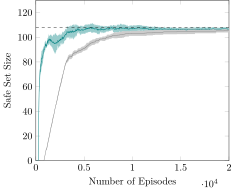

In [55]:
xmax = 20000
step = 10

ax = Axis(Plots.Linear(collect(0:step:xmax), μ_ss[1:step:xmax+1], mark="none", style="teal"))
p_pred_hi = push!(ax, Plots.Linear(collect(0:step:xmax), pred_hi[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
p_pred_lo = push!(ax, Plots.Linear(collect(0:step:xmax), pred_lo[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[teal!40] fill between[of=A and B];"))

push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssb[1:step:xmax+1], mark="none", style="gray"))
p_pred_hi = push!(ax, Plots.Linear(collect(0:step:xmax), pred_hib[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
p_pred_lo = push!(ax, Plots.Linear(collect(0:step:xmax), pred_lob[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[gray!40] fill between[of=A and B];"))

push!(ax, Plots.Linear([0.0, xmax], [108.0, 108.0], mark="none", style="black, dashed"))

ax.xmin = 0.0
ax.xmax = xmax
ax.ymin = 0.0
ax.ymax = 130.0
ax.xlabel = "Number of Episodes"
ax.ylabel = "Safe Set Size"
ax

# Random Acquisition

In [56]:
function pendulum_bandit_model(nθ, nω; σθ_max=0.2, σω_max=1.0)
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    return BanditModel(grid)
end

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

ss_r = []
for i = 1:5
    model_r = pendulum_bandit_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max)
    set_sizes_r = run_estimation!(model_r, problem, random_acquisition, 50000)
    push!(ss_r, set_sizes_r)
end

In [58]:
ss_r = hcat(ss_r...)
μ_ssr = mean(ss_r, dims=2)[:]
σ_ssr = std(ss_r, dims=2)[:];

In [59]:
@save "/scratch/smkatz/multilevelest/pendulum_results/random_baseline.bson" ss_r

# Baseline with Random

In [69]:
ss_b = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/bandit_baseline.bson")[:ss_b]
μ_ssb = mean(ss_b, dims=2)[:]
σ_ssb = std(ss_b, dims=2)[:];

In [70]:
pred_hib = μ_ssb .+ σ_ssb
pred_lob = μ_ssb .- σ_ssb;

In [71]:
pred_hir = μ_ssr .+ σ_ssr
pred_lor = μ_ssr .- σ_ssr;

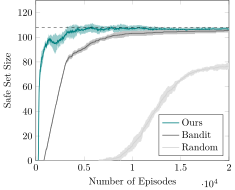

In [83]:
xmax = 20000
step = 10

ax = Axis(Plots.Linear(collect(0:step:xmax), μ_ss[1:step:xmax+1], mark="none", style="thick, teal",
            legendentry="Ours"))
p_pred_hi = push!(ax, Plots.Linear(collect(0:step:xmax), pred_hi[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
p_pred_lo = push!(ax, Plots.Linear(collect(0:step:xmax), pred_lo[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[teal!40, forget plot] fill between[of=A and B];"))

push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssb[1:step:xmax+1], mark="none", style="thick, dimgray",
        legendentry="Bandit"))
p_pred_hi = push!(ax, Plots.Linear(collect(0:step:xmax), pred_hib[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
p_pred_lo = push!(ax, Plots.Linear(collect(0:step:xmax), pred_lob[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[dimgray!40, forget plot] fill between[of=A and B];"))

push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssr[1:step:xmax+1], mark="none", style="thick, lightgray",
        legendentry="Random"))
p_pred_hi = push!(ax, Plots.Linear(collect(0:step:xmax), pred_hir[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
p_pred_lo = push!(ax, Plots.Linear(collect(0:step:xmax), pred_lor[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[lightgray!70, forget plot] fill between[of=A and B];"))

push!(ax, Plots.Linear([0.0, xmax], [108.0, 108.0], mark="none", style="black, dashed"))

ax.xmin = 0.0
ax.xmax = xmax
ax.ymin = 0.0
ax.ymax = 130.0
ax.xlabel = "Number of Episodes"
ax.ylabel = "Safe Set Size"
ax.legendPos = "south east"
ax

# GP

In [90]:
wsqe_kernel(r, W; ℓ=0.01) = exp(-(r' * W * r) / (2 * ℓ^2))

function pendulum_gp_model(nθ, nω; σθ_max=0.2, σω_max=1.0,
    ℓ=5e-3, nsamps=500, w=[1.0, 0.04])
    # Set up grid
    σθs = collect(range(0, stop=σθ_max, length=nθ))
    σωs = collect(range(0, stop=σω_max, length=nω))
    grid = RectangleGrid(σθs, σωs)

    # Set up the mean and kernel functions
    m(x) = zeros(length(x)) #0.5 * ones(length(x))
    W = diagm(w ./ norm(w))
    k(x, x′) = wsqe_kernel(x - x′, W, ℓ=ℓ)

    # Solve for variance based on coefficient of variation
    cv = √((1 - 0.1) / (0.1 * nsamps))
    ν = (0.1 * cv)^2

    return GaussianProcessModel(grid, nsamps, m, k, ν)
end

nsamps_tot = 20000
nsamps_indiv = 100

nθ = 21
nω = 21
σθ_max = 0.2
σω_max = 1.0
problem = pendulum_problem(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, conf_threshold=0.95)

MILE_acquisition(model) = MILE_acquisition(model, problem.pfail_threshold, problem.conf_threshold)

ss_gp = []
for i = 1:5
    model_gp = pendulum_gp_model(nθ, nω, σθ_max=σθ_max, σω_max=σω_max, nsamps=nsamps_indiv, ℓ=1e-1)
    set_sizes_gp = run_estimation!(model_gp, problem, MILE_acquisition, nsamps_tot)
    push!(ss_gp, set_sizes_gp)
end

In [91]:
ss_gp = hcat(ss_gp...)
μ_ssgp = mean(ss_gp, dims=2)[:]
σ_ssgp = std(ss_gp, dims=2)[:];

In [92]:
@save "/scratch/smkatz/multilevelest/pendulum_results/gp_baseline.bson" ss_gp

# GP Comparison

In [93]:
pred_higp = μ_ssgp .+ σ_ssgp
pred_logp = μ_ssgp .- σ_ssgp;

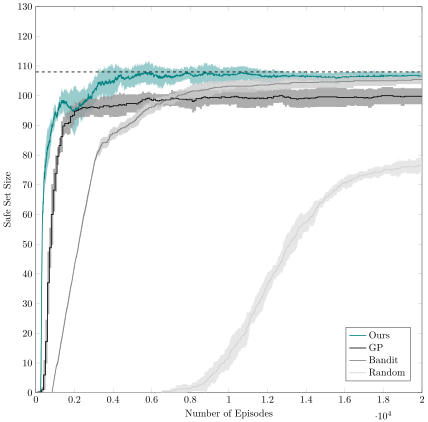

In [109]:
xmax = 20000
step = 1

ax = Axis(Plots.Linear(collect(0:step:xmax), μ_ss[1:step:xmax+1], mark="none",
        style="thick, teal", legendentry="Ours"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_hi[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lo[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[teal!40, forget plot] fill between[of=A and B];"))

end_ind = convert(Int64, floor(xmax / nsamps_indiv) + 1)
push!(ax, Plots.Linear(collect(0:nsamps_indiv:xmax), pred_higp[1:end_ind], style="draw=none, mark=none, const plot, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv:xmax), pred_logp[1:end_ind], style="draw=none, mark=none, const plot, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[black!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv:xmax), μ_ssgp[1:end_ind], mark="none",
        style="thick, black, const plot", legendentry="GP"))

push!(ax, Plots.Linear(collect(0:step:xmax), pred_hib[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lob[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[gray!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssb[1:step:xmax+1], mark="none", style="thick, gray",
        legendentry="Bandit"))

push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssr[1:step:xmax+1], mark="none", style="thick, lightgray",
        legendentry="Random"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_hir[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lor[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[lightgray!70, opacity=0.8, forget plot] fill between[of=A and B];"))

push!(ax, Plots.Linear([0.0, xmax], [108.0, 108.0], mark="none", style="thick, black, dashed"))

ax.xmin = 0.0
ax.xmax = xmax
ax.ymin = 0.0
ax.ymax = 130.0
ax.xlabel = "Number of Episodes"
ax.ylabel = "Safe Set Size"
ax.legendPos = "south east"
ax.width = "6in"
ax.height = "6in"
ax

# From Full Load In

In [11]:
ss1 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run1.bson")[:set_sizes_kkb]
ss2 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run2.bson")[:set_sizes_kkb]
ss3 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run3.bson")[:set_sizes_kkb]
ss4 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run4.bson")[:set_sizes_kkb]
ss5 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/run5.bson")[:set_sizes_kkb]

ss1k = [s[2] for s in ss1]
ss2k = [s[2] for s in ss2]
ss3k = [s[2] for s in ss3]
ss4k = [s[2] for s in ss4]
ss5k = [s[2] for s in ss5]

ss = hcat(ss1k, ss2k, ss3k, ss4k, ss5k)
μ_ss = mean(ss, dims=2)[:]
σ_ss = std(ss, dims=2)[:]

pred_hi = μ_ss .+ σ_ss
pred_lo = μ_ss .- σ_ss

ss_b = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/bandit_baseline.bson")[:ss_b]
μ_ssb = mean(ss_b, dims=2)[:]
σ_ssb = std(ss_b, dims=2)[:]

pred_hib = μ_ssb .+ σ_ssb
pred_lob = μ_ssb .- σ_ssb

ss_r = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/random_baseline.bson")[:ss_r]
μ_ssr = mean(ss_r, dims=2)[:]
σ_ssr = std(ss_r, dims=2)[:]

pred_hir = μ_ssr .+ σ_ssr
pred_lor = μ_ssr .- σ_ssr

ss_gp2 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/gp_baseline_5000.bson")[:ss_gp]
μ_ssgp2 = mean(ss_gp2, dims=2)[:]
σ_ssgp2 = std(ss_gp2, dims=2)[:]

pred_higp2 = μ_ssgp2 .+ σ_ssgp2
pred_logp2 = μ_ssgp2 .- σ_ssgp2

ss_gp1 = BSON.load("/scratch/smkatz/multilevelest/pendulum_results/gp_baseline.bson")[:ss_gp]
μ_ssgp1 = mean(ss_gp1, dims=2)[:]
σ_ssgp1 = std(ss_gp1, dims=2)[:]

pred_higp1 = μ_ssgp1 .+ σ_ssgp1
pred_logp1 = μ_ssgp1 .- σ_ssgp1;

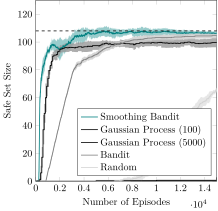

In [21]:
nsamps_indiv_1 = 100
nsamps_indiv_2 = 5000

xmax = 15000
step = 1

ax = Axis(Plots.Linear(collect(0:step:xmax), μ_ss[1:step:xmax+1], mark="none",
    style="thick, teal", legendentry="Smoothing Bandit"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_hi[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lo[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[teal!40, forget plot] fill between[of=A and B];"))

end_ind = convert(Int64, floor(xmax / nsamps_indiv_1) + 1)
push!(ax, Plots.Linear(collect(0:nsamps_indiv_1:xmax), pred_higp1[1:end_ind], style="draw=none, mark=none, const plot, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv_1:xmax), pred_logp1[1:end_ind], style="draw=none, mark=none, const plot, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[black!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv_1:xmax), μ_ssgp1[1:end_ind], mark="none",
    style="thick, black, const plot", legendentry="Gaussian Process (100)"))

end_ind = convert(Int64, floor(xmax / nsamps_indiv_2) + 1)
push!(ax, Plots.Linear(collect(0:nsamps_indiv_2:xmax), pred_higp2[1:end_ind], style="draw=none, mark=none, const plot, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv_2:xmax), pred_logp2[1:end_ind], style="draw=none, mark=none, const plot, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[black!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:nsamps_indiv_2:xmax), μ_ssgp2[1:end_ind], mark="none",
    style="thick, black, const plot", legendentry="Gaussian Process (5000)"))

push!(ax, Plots.Linear(collect(0:step:xmax), pred_hib[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lob[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[gray!40, opacity=0.8, forget plot] fill between[of=A and B];"))
push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssb[1:step:xmax+1], mark="none", style="thick, gray",
    legendentry="Bandit"))

push!(ax, Plots.Linear(collect(0:step:xmax), μ_ssr[1:step:xmax+1], mark="none", style="thick, lightgray",
    legendentry="Random"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_hir[1:step:xmax+1], style="draw=none, mark=none, name path=A, forget plot"))
push!(ax, Plots.Linear(collect(0:step:xmax), pred_lor[1:step:xmax+1], style="draw=none, mark=none, name path=B, forget plot"))
push!(ax, Plots.Command("\\addplot[lightgray!70, opacity=0.8, forget plot] fill between[of=A and B];"))

push!(ax, Plots.Linear([0.0, xmax], [108.0, 108.0], mark="none", style="thick, black, dashed"))

ax.xmin = 0.0
ax.xmax = xmax
ax.ymin = 0.0
ax.ymax = 130.0
ax.xlabel = "Number of Episodes"
ax.ylabel = "Safe Set Size"
ax.legendPos = "south east"
ax.width = "8cm"
ax.height = "8cm"
PGFPlots.save("pend_results.tex", ax, include_preamble=false)
ax